# Credit Card Approval Fairness
Machine learning and deep learning models have been proven to be successful in the domain of credit card fraud detection for its outstanding predicting power. However, in spite of the outstanding predicting ability, these new techniques are receiving more and more criticism from the public due to their bias in fairness. Even though two individuals are equally honest in nature, they may have very different chances of being approved by the credit card issuer because they have different ages or genders.
We begin our project from discovering the deterioration in fairness as more complicated machine learning models are replacing the logistic models. In the task of predicting approvals of credit cards, figure 1 shows the random forest proves to be more effective than logistic. Figure 2 plots the cdf function difference of predicted probabilies between different genders. For the same proprotion number of samples, logistic model gives higher probabilites of approval than random forest.  

In [1]:
import torch
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score,auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
pd.set_option("display.max_columns", None)

In [2]:
data = pd.read_csv("./data/application_record.csv", encoding = 'utf-8')
record = pd.read_csv("./data/credit_record.csv", encoding = 'utf-8')

In [3]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="inner",on="ID") #merge to record data
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0
new_data.drop('FLAG_MOBIL', axis=1, inplace=True)
new_data.drop('dep_value', axis=1, inplace=True)

In [4]:
new_data.rename(columns={'CODE_GENDER':'gender','FLAG_OWN_CAR':'car','FLAG_OWN_REALTY':'reality',
                         'CNT_CHILDREN':'chilno','AMT_INCOME_TOTAL':'income',
                         'NAME_EDUCATION_TYPE':'edu','NAME_FAMILY_STATUS':'family',
                        'NAME_HOUSING_TYPE':'house','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp', 'DAYS_BIRTH': 'dsbir', 'DAYS_EMPLOYED': 'dsemply',
                        },inplace=True)

In [5]:
# gender
new_data.loc[new_data["gender"]=="M", "gender"]=1
new_data.loc[new_data["gender"]=="F", "gender"]=0
# car
new_data.loc[new_data["car"]=="Y", "car"]=1
new_data.loc[new_data["car"]=="N", "car"]=0
# reality
new_data.loc[new_data["reality"]=="Y", "reality"]=1
new_data.loc[new_data["reality"]=="N", "reality"]=0
# chilno
new_data['childn1'] = 0
new_data['childn2'] = 0
new_data['childn3'] = 0

new_data.loc[new_data["chilno"]==1, "childn1"]=1
new_data.loc[new_data["chilno"]==2, "childn2"]=1
new_data.loc[new_data["chilno"]>2, "childn3"]=1
# inctp
new_data['pensioner'] = 0
new_data['student'] = 0
new_data['working'] = 0
new_data['gov'] = 0
new_data['associate'] = 0

new_data.loc[new_data["inctp"]=="Pensioner", "pensioner"]=1
new_data.loc[new_data["inctp"]=="Student", "student"]=1
new_data.loc[new_data["inctp"]=="Working", "working"]=1
new_data.loc[new_data["inctp"]=="State servant", "gov"]=1
new_data.loc[new_data["inctp"]=="Commercial associate", "associate"]=1
#edu
new_data['loweredu'] = 0
new_data['secondedu'] = 0
new_data['inhigheredu'] = 0
new_data['higeredu'] = 0
new_data['acadedu'] = 0

new_data.loc[new_data["edu"]=="Lower secondary", "loweredu"]=1
new_data.loc[new_data["edu"]=="Secondary / secondary special", "secondedu"]=1
new_data.loc[new_data["edu"]=="Incomplete higher", "inhigheredu"]=1
new_data.loc[new_data["edu"]=="Higher education", "higheredu"]=1
new_data.loc[new_data["edu"]=="Academic degree", "acaedu"]=1
#marriage
new_data["married"] = 0
new_data["single"] = 0
new_data["seperated"] = 0
new_data["widow"] = 0

new_data.loc[new_data["family"]=="Civil marriage", "married"]=1
new_data.loc[new_data["family"]=="Married", "married"]=1
new_data.loc[new_data["family"]=="Single / not married", "single"]=1
new_data.loc[new_data["family"]=="Seperated", "seperated"]=1
new_data.loc[new_data["family"]=="Widow", "widow"]=1

# apartment
new_data["rent"] = 0
new_data["house"] = 0
new_data["withparents"] = 0
new_data["coop"] = 0
new_data["apartment"] = 0

new_data.loc[new_data["house"]=="Rented apartment", "rent"]=1
new_data.loc[new_data["house"]=="House / apartment","house"]=1
new_data.loc[new_data["house"]=="With parents", "withparents"]=1
new_data.loc[new_data["house"]=="Co-op apartment", "coop"]=1
new_data.loc[(new_data["house"]=="Municipal apartment") | (new_data["house"]=="Office apartment"), "apartment"]=1

# occupation
new_data['labor'] = 0
new_data['white_collar'] = 0
new_data['manager'] = 0
new_data['no_occyp'] = 0
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'labor']=1
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'white_collar']=1
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'manager']=1
new_data.loc[new_data['occyp'].isna(), "no_occyp"]=1

new_data['worktm']=-(new_data['dsemply'])//365	
new_data[new_data['worktm']<0] = np.nan
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean

new_data['fam1'] = 0
new_data['fam2'] = 0
new_data['fam3'] = 0
new_data['fam4'] = 0

new_data.loc[new_data['famsize']==1, 'fam1'] = 1
new_data.loc[new_data['famsize']==2, 'fam2'] = 1
new_data.loc[new_data['famsize']==3, 'fam3'] = 1
new_data.loc[new_data['famsize']>=4, 'fam4']=1

new_data['age']=-(new_data['dsbir'])//365	

cat_cols = ['gender', 'car', 'reality', 'house', 'wkphone', 'phone', 'email', 
            'childn1', 'childn2', 'childn3', 'pensioner', 'student', 'working', 'gov', 'associate',
            'loweredu', 'secondedu', 'inhigheredu', 'acadedu', 'married', 'single', 'seperated', 'widow', 
            'rent', 'withparents', 'coop', 'apartment', 'labor', 'white_collar', 'manager', 'no_occyp',
            'fam1', 'fam2', 'fam3', 'fam4']

cont_cols = ['income', 'worktm', 'age']

target = ['target']

prepared_data = new_data[cat_cols+cont_cols+target]

prepared_data = prepared_data.dropna()

for cat in cat_cols:
    prepared_data[cat] = prepared_data[cat].astype('int')


In [6]:
prepared_data

,gender,car,reality,house,wkphone,phone,email,childn1,childn2,childn3,pensioner,student,working,gov,associate,loweredu,secondedu,inhigheredu,acadedu,married,single,seperated,widow,rent,withparents,coop,apartment,labor,white_collar,manager,no_occyp,fam1,fam2,fam3,fam4,income,worktm,age,target
0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,427500.0,12.0,32.0,0
1,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,427500.0,12.0,32.0,0
2,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,112500.0,3.0,58.0,0
3,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,270000.0,8.0,52.0,0
4,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,270000.0,8.0,52.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,315000.0,6.0,47.0,1
36453,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,157500.0,3.0,33.0,1
36454,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,157500.0,3.0,33.0,1
36455,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,283500.0,1.0,49.0,1


In [7]:
Y = prepared_data['target'].astype('int')
X = prepared_data[[i for i in prepared_data.columns if (i != 'ID') and (i != 'target')]]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, 
                                                    stratify=Y, test_size=0.3,
                                                    random_state = 52)

tonormcols = ["income", "worktm", "age"]
for i in tonormcols:
    mean = X_train[i].mean()
    std = X_train[i].std()
    X_train[i] = (X_train[i]-mean)/std
    X_test[i] = (X_test[i]-mean)/std

In [9]:
cat_idxs = list(range(len(cat_cols)))
sampler = SMOTENC(categorical_features=cat_idxs, n_jobs=-1)
# sampler = SMOTEENN(n_jobs=-1)
X_train, y_train = sampler.fit_resample(X_train, y_train)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [10]:
models = {"Logistic": LogisticRegression(n_jobs=-1), "Random Forest": RandomForestClassifier(n_estimators=100,n_jobs=-1)}

In [11]:
def roc_cal(y_true, probas):
    fpr, tpr, theshold = roc_curve(y_true, probas)
    return fpr, tpr

def train_models(model_dict, x, y):
    for model_name, model in model_dict.items():
        model.fit(x,y)
        model_dict[model_name] = model
    return model_dict

def evaluate_performance(model_dict, x, y):
    out = {}
    for model_name, model in model_dict.items():
        metrics = ["acc", "precision", "recall", "f1", "auc"]
        y_pred = model.predict(x)
        y_true = y
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        probas = model.predict_proba(x)[:,1]
        auc = roc_auc_score(y_true, probas)
        metrics_dict = dict(zip(metrics,np.array([acc,precision,recall,f1,auc])))
        out[model_name] = metrics_dict
    return out


In [12]:
import warnings
warnings.filterwarnings('ignore')
model_dict_trained = train_models(models, X_train, y_train)
evaluate_performance(model_dict_trained, X_test, y_test)

{'Logistic': {'acc': 0.6371331208090579,
  'precision': 0.018053855569155446,
  'recall': 0.39072847682119205,
  'f1': 0.03451301550160866,
  'auc': 0.52748018649054},
 'Random Forest': {'acc': 0.9790040672749258,
  'precision': 0.3,
  'recall': 0.1986754966887417,
  'f1': 0.2390438247011952,
  'auc': 0.8091018517284723}}

In [13]:
def plot_roc(model_dict, x, y, ax):
    sns.set_theme(style="whitegrid")
    ax.set_title('Receiver Operating Characteristic')

    for model_name, model in model_dict.items():
        probs = model.predict_proba(x)[:,1]
        fpr, tpr = roc_cal(y, probs)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr,label = '{} AUC = {:.2f}'.format(model_name, roc_auc))

    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

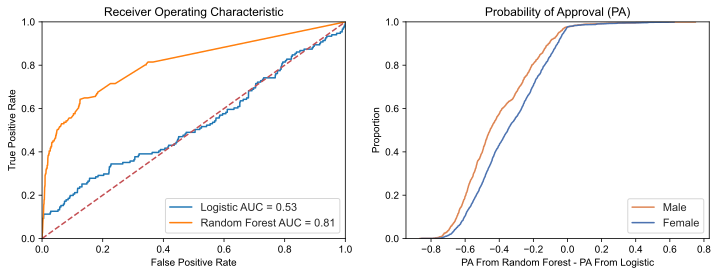

In [14]:
logiprobs = model_dict_trained["Logistic"].predict_proba(X_test)
rfprobs = model_dict_trained["Random Forest"].predict_proba(X_test)
probdata = pd.DataFrame()
probdata["logiprob"] = logiprobs[:,1]
probdata["rfprob"] = rfprobs[:,1]
probdata["diff"] = probdata["rfprob"] - probdata["logiprob"]
probdata["gender"] = X_test["gender"]


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plot_roc(model_dict_trained, X_test, y_test, ax=axs[0])

sns.set_style(style="whitegrid")
sns.ecdfplot(data=probdata, x="diff", hue="gender", ax=axs[1])
axs[1].legend(["Male", "Female"], loc="lower right")
axs[1].set_xlabel("PA From Random Forest - PA From Logistic")
axs[1].set_title("Probability of Approval (PA)")
plt.show()

In [15]:
n = 20
personOne = X_test.iloc[[n]]
personOne = pd.concat([personOne, personOne]).reset_index(drop=True)
personOne.loc[0, "gender"] = 1
print(model_dict_trained["Random Forest"].predict_proba(personOne))
print(model_dict_trained["Logistic"].predict_proba(personOne))

[[0.71 0.29]
 [0.93 0.07]]
[[0.86165625 0.13834375]
 [0.87926042 0.12073958]]
